# Notebook imports

In [91]:
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns


import matplotlib.pyplot as plt

from wyrm import plot as pt

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from wyrm import processing as proc
from wyrm.types import Data

import warnings
warnings.filterwarnings('ignore')

# Constants

In [92]:
DATA_FILE = "preprocessed_motor_imagery.csv"
TRAIN_LABELS = "train_labels.csv"
TEST_LABELS = "test_labels.csv"

# Load Data

In [93]:
data = pd.read_csv(DATA_FILE)
data.head()

,1,2,3,4,5,6,7,8
0,-750.803511,486.705886,16.329855,-934.211230,-226.426943,-527.669718,82.016818,645.467436
1,-4723.440890,3069.026544,116.509932,-5799.878400,-1401.575705,-3249.831866,520.220124,3985.649834
2,-12831.117329,8373.375049,365.076691,-15479.724786,-3743.864216,-8546.710003,1432.324527,10540.629666
3,-20211.000688,13285.273611,656.324083,-23913.357629,-5843.627842,-12883.378940,2301.162509,16057.481102
4,-21638.723649,14350.569332,739.703468,-25366.172785,-6356.361383,-13270.504686,2514.918974,16782.390676


In [94]:
data.shape

(150000, 8)

In [95]:
train_labels = pd.read_csv(TRAIN_LABELS, index_col=0)
test_labels = pd.read_csv(TEST_LABELS, index_col=0)

In [96]:
train_labels.shape

(48, 1)

In [97]:
test_labels.shape

(12, 1)

# Data preprocessing

In [98]:
df_eeg_data = data[['1', '2', '3', '4', '5', '6', '7', '8']]

In [99]:


# Split the data into train, test sets
train_data, test_data = train_test_split(df_eeg_data, test_size=0.2, shuffle=False, random_state=13) 


In [100]:
print(train_data.shape)
print(test_data.shape)

(120000, 8)
(30000, 8)


In [101]:
# Converting the training and test data into numpy array
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()

In [102]:
# Epoch Data into 10 seconds windows

# length of window (in seconds)
window_length = 10
fs = 250
window_size_hz = int(window_length*fs)  # window size in Hertz

# Epoching train data  (120000/2500 = 48)
for filtered in train_data.T:
    epoched_train = []
    i = 0
    while (i < len(train_data)):
        epoched_train.append(train_data[i:(i+window_size_hz)])
        i += window_size_hz
    data_train = np.array(epoched_train)

# Epoching Test data 
for filtered in test_data.T:
    epoched_test = []
    i = 0
    while(i < len(test_data)):
        epoched_test.append(test_data[i: (i+window_size_hz)])
        i += window_size_hz
    data_test = np.array(epoched_test)
    

In [103]:
print(f'Shape of training data is: {data_train.shape}')
print(f'Shape of testing data is : {data_test.shape}')

Shape of training data is: (48, 2500, 8)
Shape of testing data is : (12, 2500, 8)


In [104]:
# flattening train and test data sets (if it is alredy flatten, then do nothing)
try:
    train_labels = train_labels.to_numpy().flatten()
    test_labels = test_labels.to_numpy().flatten()
except:
    pass

In [105]:
print(f'Shape of training labels: {train_labels.shape}')
print(f'Shape of testing lables: {test_labels.shape}')

Shape of training labels: (48,)
Shape of testing lables: (12,)


In [106]:
# Converting the training and testing data into wyrm data format
# Wyrm is a Brain-Computer Interface Toolbox in Python

# Wyrm Data Attributes: 1.axes 2.names 3.units
# Initialize the First Attribute (Axes: describes the  dimension of the data)

# 1. converting the training data to wyrm data format 
axes = [np.arange(i) for i in data_train.shape]
# Assign the training labes (48) to axes[0]
axes[0] = train_labels
axes[2] = [str(i) for i in range(data_train.shape[2])]

# Initialize the 2nd and 3rd attributes 
# Name: Describe the name of each dimension of data 
#Units: The units of the dimensions)
names = ['Class', 'Time', 'Channel']
units = ['#', 'ms', '#']

training_data = Data(data=data_train, axes=axes, names=names, units=units)         # Data is imported from wyrm
training_data.fs = fs  # fs = 250

# We are dealing with a binary classifcation task. 2 Classes(hands, feet)
training_data.class_names = ['hands', 'feet']
# Our labels are 1 and 2s. Let's convert them to 0s and 1s for the classification

training_data.axes[0][training_data.axes[0] == 2] = 0

# 2. converting the testing data to wyrm data format
axes = [np.arange(i) for i in data_test.shape]
axes[2] = [str(i) for i in range(data_test.shape[2])]
# Assign 12 Labels to axes[0]
axes[0] = test_labels

testing_data = Data(data=data_test, axes=axes, names=names, units=units)
testing_data.fs = fs  # fs = 250
testing_data.class_names = ['hands', 'feet']
testing_data.axes[0][testing_data.axes[0] == 2] = 0


## Visualizing the data

Text(0.5, 1.0, 'Time interval plot for test data before processing')

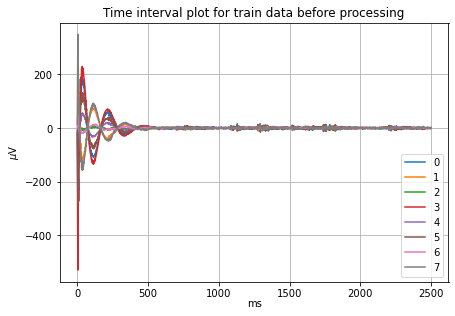

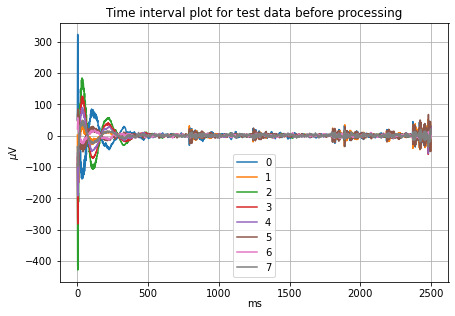

In [107]:
pt.plot_timeinterval(training_data)
plt.title("Time interval plot for train data before processing")

pt.plot_timeinterval(testing_data)
plt.title("Time interval plot for test data before processing") 

In [108]:
# Preprocess the data

def preprocess_data(train_data, test_data):
    """
        This functionc reduces noise by filtering the data with 0.9 hz high-pass filter and 15 hz low-pass filters.
        This is achieved by applying butterworth filters accompanied by low pass and high pass filter.
    """
    fsm = train_data.fs/2
    #filtering the training data
    c,a = proc.signal.butter(8, [15/fsm], btype='low')  # the proc module is imported from the wyrm package
    train_data = proc.lfilter(train_data, c, a)
    c,a = proc.signal.butter(8, 0.9/fsm, btype='high')
    train_data = proc.lfilter(train_data, c, a)
    
    #filtering the test data
    c,a = proc.signal.butter(8, [15/fsm], btype='low')
    test_data = proc.lfilter(test_data, c, a)
    c,a = proc.signal.butter(8, 0.9/fsm, btype='high')
    test_data = proc.lfilter(test_data, c, a)
    
    
    # plotting the resulting data sets to visualize
    pt.plot_timeinterval(train_data)
    plt.title("Time interval plot for train data after filtering")
    
    pt.plot_timeinterval(test_data)
    plt.title("Time interval plot for test data after filtering")
    
    # applying common spatial pattern
    filt, pattern, _ = proc.calculate_csp(train_data)
    train_data = proc.apply_csp(train_data, filt)
    test_data = proc.apply_csp(test_data, filt)
    
    train_data = proc.variance(train_data, 1)
    train_data = proc.logarithm(train_data)
    
    test_data = proc.variance(test_data, 1)
    test_data = proc.logarithm(test_data)
    
    train_data = proc.rectify_channels(train_data)
    test_data = proc.rectify_channels(test_data)
    
    train_data = proc.square(train_data)
    test_data = proc.square(test_data)
    
    return train_data, test_data

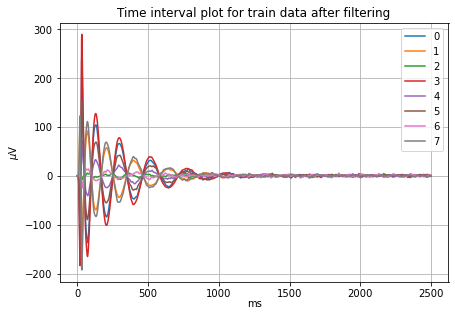

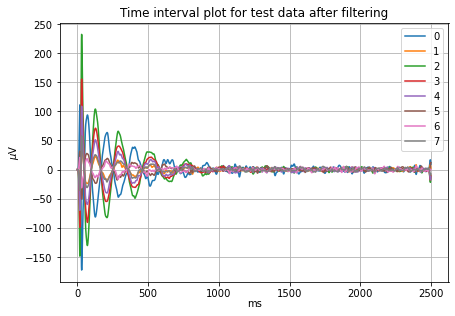

In [109]:
fvtr, fvte = preprocess_data(training_data, testing_data)

In [119]:
test_labels[test_labels == 2] = 0
test_labels

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [120]:
# convert the test_labels to float
labels_test = test_labels/1 
labels_test 

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.])

In [121]:
train_labels[train_labels == 2] = 0
train_labels

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0], dtype=int64)

## Linear Descriptive Analysis (LDA) Classification

In [122]:
cfy = proc.lda_train(fvtr)
result=proc.lda_apply(fvte,cfy)
result1=(np.sign(result)+1)/2

In [130]:
result1

array([1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.])

In [126]:
sum=0.0
for i in range(len(result1)):
    if result1[i]==labels_test[i]:
        sum=sum+1
lda_acc=sum/(len(result))


In [124]:
print(f"The accuracy of the LDA model is {lda_acc:.2%}")

The accuracy of the LDA model is 66.67%


In [125]:
# Let's create a confusion matrix to visualize the results
def conf_metrics (conf_mat):
# save confusion matrix and slice into four pieces
    TP = conf_mat[1][1]
    TN = conf_mat[0][0]
    FP = conf_mat[0][1]
    FN = conf_mat[1][0]
    print(f"True Positives: {TP}")
    print(f"True Negatives: {TN}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    
    print('-'*60)  # for decoration purpose
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [64]:
conf_m = confusion_matrix(test_labels, result1)

conf_metrics(conf_m)

True Positives: 4
True Negatives: 4
False Positives: 2
False Negatives: 2
------------------------------------------------------------
Accuracy: 0.67
Mis-Classification: 0.33
Sensitivity: 0.67
Specificity: 0.67
Precision: 0.67
f_1 Score: 0.67


## RandomForest Classifier

In [75]:
rf_model = RandomForestClassifier(max_depth=5, n_estimators=50, n_jobs=1)
rf_model.fit(fvtr.data, train_labels)

rf_model_predict = rf_model.predict(fvte.data)
rf_model_acc = accuracy_score(test_labels, rf_model_predict)

In [76]:
cm = confusion_matrix(test_labels, rf_model_predict)
conf_metrics(cm)

True Positives: 3
True Negatives: 3
False Positives: 3
False Negatives: 3
------------------------------------------------------------
Accuracy: 0.5
Mis-Classification: 0.5
Sensitivity: 0.5
Specificity: 0.5
Precision: 0.5
f_1 Score: 0.5


## K-Nearest Neighbors Classifier

In [84]:
knn = KNeighborsClassifier()
knn.fit(fvtr.data, train_labels)

knn_pred = knn.predict(fvte.data)
k_acc = accuracy_score(test_labels, knn_pred)

In [85]:
cm = confusion_matrix(test_labels, knn_pred)
conf_metrics(cm)

True Positives: 4
True Negatives: 2
False Positives: 4
False Negatives: 2
------------------------------------------------------------
Accuracy: 0.5
Mis-Classification: 0.5
Sensitivity: 0.67
Specificity: 0.33
Precision: 0.5
f_1 Score: 0.57


## Model comparison

Text(0.5, 0, 'Accuracy in percentage')

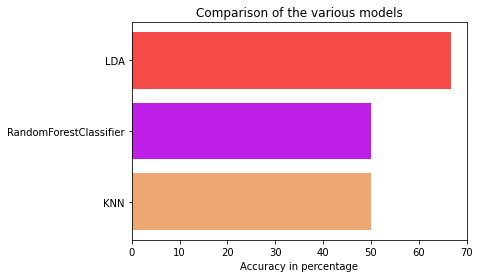

In [87]:
X_bar = ['KNN', 'RandomForestClassifier', 'LDA']
Y_bar = [k_acc*100, rf_model_acc*100, lda_acc*100]

plt.barh(X_bar, Y_bar, align='center', color=('#EEA773', '#BE20E7', '#F54B48'))
plt.title("Comparison of the various models")
plt.xlabel("Accuracy in percentage")
